In [26]:
import numpy as np
import plotly.express as ex
import pandas as pd

In [27]:
def to_df(np_array, col_prefix='x'):
    d = {}
    for i, column in enumerate(np.array(np_array).T):
        d[col_prefix + str(i)] = column
    return pd.DataFrame(d)

In [114]:
def acf(x, length=20):
    cor = np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])
    return ex.bar(y=cor)

# Target model

In [43]:
class StraightLineTarget:
    def __init__(self):
        pass

    def positions(self, t):
        t = np.array(t)
        x = np.full_like(t, 0)
        y = np.full_like(t, 0)
        z = np.arange(0, len(t))
        return np.array((x, y, z)).T

# Measurements

In [3]:
def cartesian_measurements(positions, noise_covariance):
    noise_mean = np.full(positions.shape[1], 0)
    noise = np.random.multivariate_normal(noise_mean, noise_covariance, size=positions.shape[0])
    return positions + noise

In [4]:
target = Target()

time = np.arange(0, 100)
meas = cartesian_measurements(target.positions(time), np.diag([1, 1, 1]))

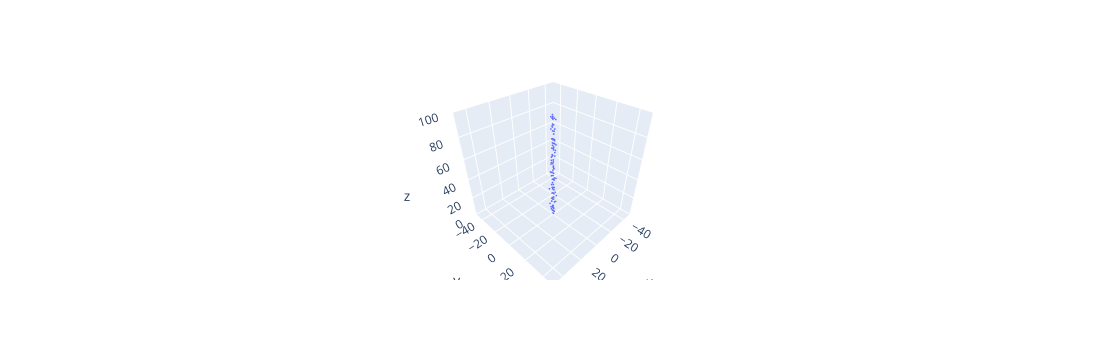

In [15]:
fig=ex.scatter_3d(x=meas[:,0],y=meas[:,1],z=meas[:,2], range_x=(-50, 50), range_y=(-50, 50), range_z=(0, 100))
fig.update_traces(marker_size = 1)
fig

# Kalman filter

In [22]:
class KalmanFilter:
    def __init__(self, x=np.zeros(6), P=np.eye(6), R=np.eye(3), Q=np.eye(6)):
        self.dim = 3                                                  # number of spatial dimensions
        self.R = np.array(R); self.R.shape = (self.dim, self.dim)     # measurement noise
        self.Q = np.array(Q); self.Q.shape = (self.dim*2, self.dim*2) # process noise
        self.x = np.array(x); self.x.shape = (self.dim*2)             # state (mean)
        self.P = np.array(P); self.P.shape = (self.dim*2, self.dim*2) # state (covariance)
        self.H = np.array([[1, 0, 0, 0, 0, 0],                        # measurement matrix
                           [0, 1, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0]])
        
    # state transition matrix
    def F(self, dt):
        return np.array([[1, 0, 0, dt, 0, 0],
                         [0, 1, 0, 0, dt, 0],
                         [0, 0, 1, 0, 0, dt],
                         [0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 0, 1]])

    # extrapolate state and uncertainty
    def predict(self, dt):
        F = self.F(dt)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + self.Q

    # update state with a measurement
    def update(self, z):
        z = np.array(z); z.shape = self.dim # measurement

        # Kalman gain
        # K = P*H (H*P*H + R)
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)

        # filtered state (mean)
        # X = X + K(z - H*X)
        self.x = self.x + K @ (z - self.H @ self.x)

        I = np.eye(6)
        
        # filtered state (covariance)
        # P = (I - K*H) * P * (I - K*H) + K*R*K
        self.P = (I - K@self.H) @ self.P @ (I - K@self.H).T + K @ self.R @ K.T

# Filtering evaluation

In [53]:
def evaluate(target, time=np.arange(0, 100), z_sigma=.1):
    # calculate target positions over time
    time = np.arange(0, 100)
    positions = target.positions(time)
    
    # transform positions into measurements
    z_var = z_sigma*z_sigma
    meas = cartesian_measurements(positions, np.diag([z_var, z_var, z_var]))
    
    # initialize track state
    mean = np.full(6, 0)
    mean[:3] = meas[0,:]
    cov = np.diag(np.full(6, z_var))
    
    kf = KalmanFilter(mean, cov)

    # iterate
    err = []
    pos = []
    vel = []
    
    for dt, z in zip(np.diff(time), meas):
        kf.predict(dt)
        pos.append(kf.x[:3])
        vel.append(kf.x[3:])
        err.append(kf.x[:3] - z)
        kf.update(z)
    
    return positions, np.array(pos), np.array(vel), np.array(err)

# Straight line

In [54]:
target, pos, vel, err = evaluate(StraightLineTarget(), z_sigma = .1)

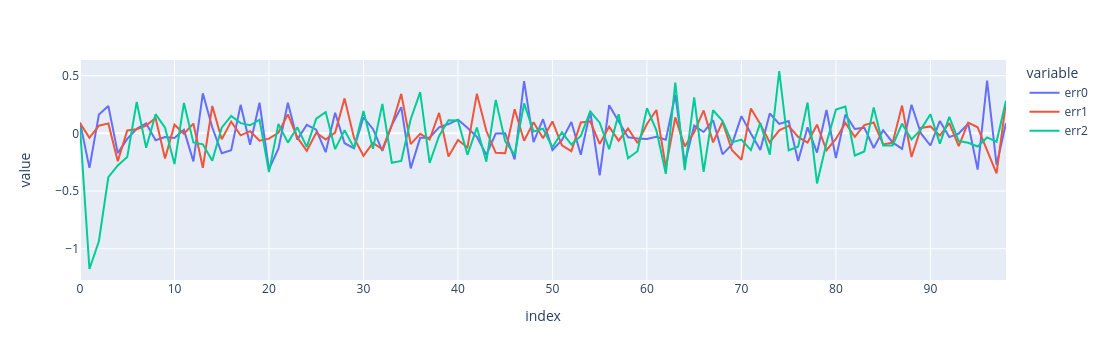

In [55]:
ex.line(to_df(err, 'err'))

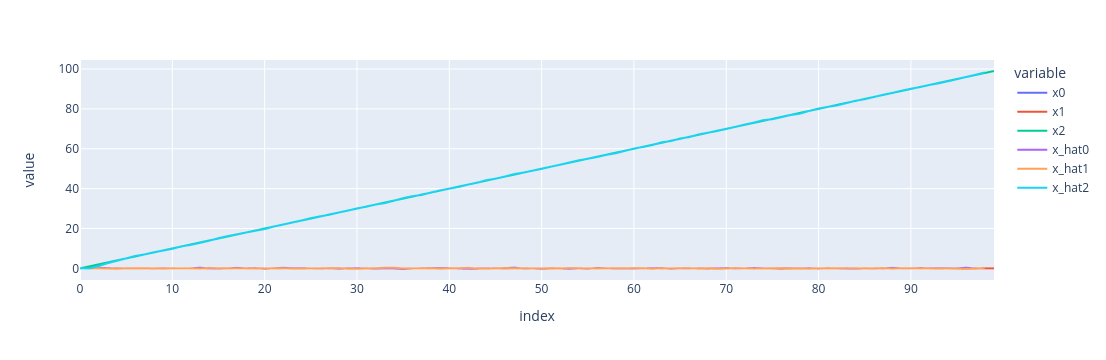

In [56]:
ex.line(pd.concat((to_df(target, 'x'), to_df(pos, 'x_hat'))))

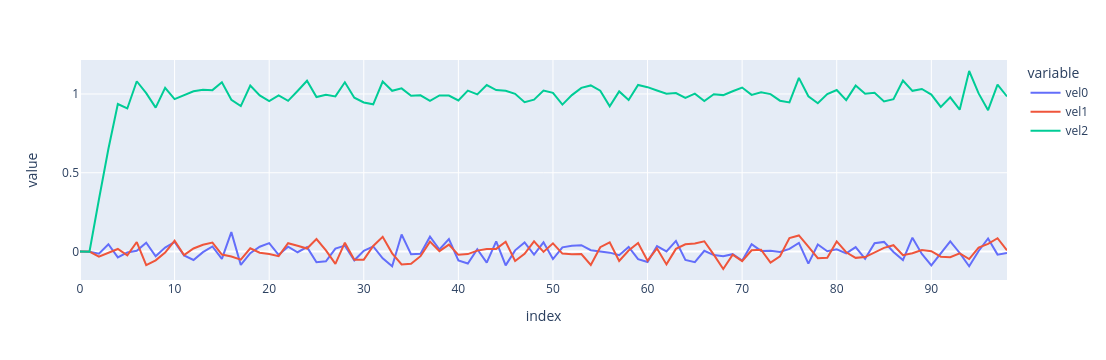

In [48]:
ex.line(to_df(vel, 'vel'))

# Sinus

In [99]:
class SinusTarget:
    def __init__(self, speed=20, range=10):
        self.speed = speed
        self.range = range

    def positions(self, t):
        t = np.array(t)
        x = np.sin(t / 180 * np.pi * self.speed) * self.range
        y = np.full_like(t, 0)
        z = np.arange(0, len(t))
        return np.array((x, y, z)).T

In [105]:
target, pos, vel, err = evaluate(SinusTarget(), z_sigma = .5)

In [106]:
fig=ex.scatter_3d(x=target[:,0],y=target[:,1],z=target[:,2], range_x=(-50, 50), range_y=(-50, 50), range_z=(0, 100))
fig.update_traces(marker_size = 1)
fig

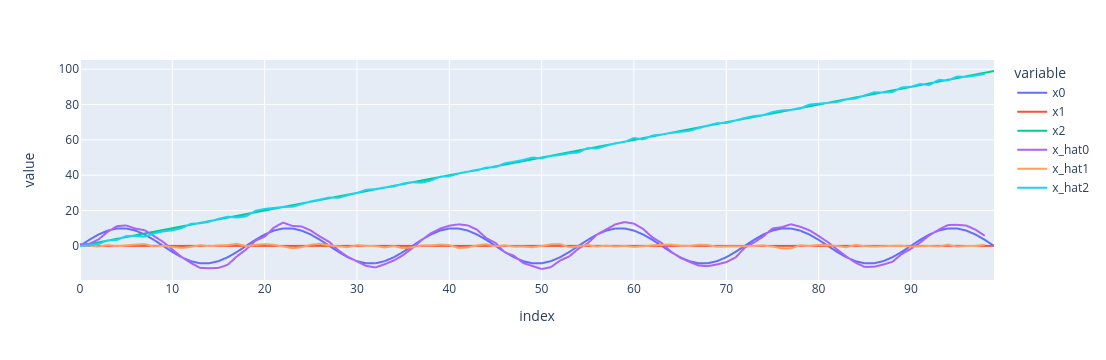

In [107]:
ex.line(pd.concat((to_df(target, 'x'), to_df(pos, 'x_hat'))))

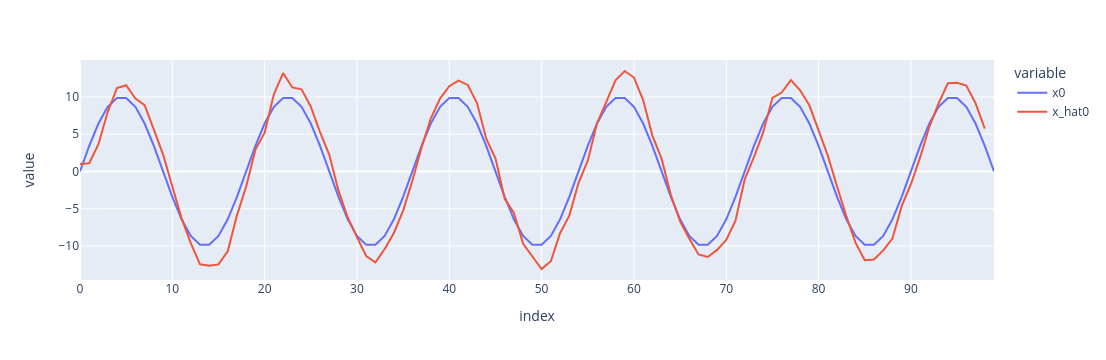

In [115]:
ex.line(pd.concat((to_df(target, 'x'), to_df(pos, 'x_hat')))[['x0', 'x_hat0']])

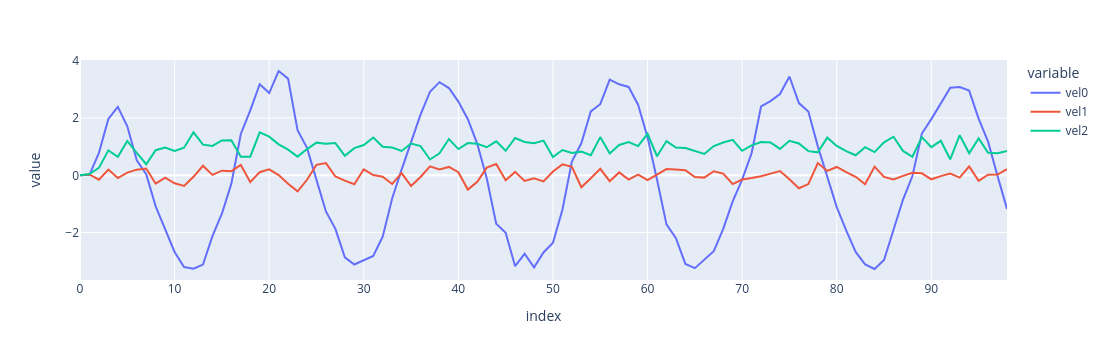

In [108]:
ex.line(to_df(vel, 'vel'))

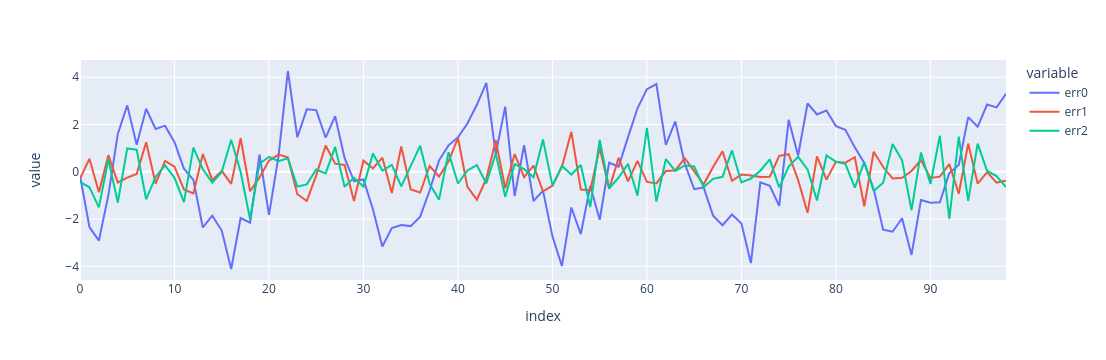

In [109]:
ex.line(to_df(err, 'err'))

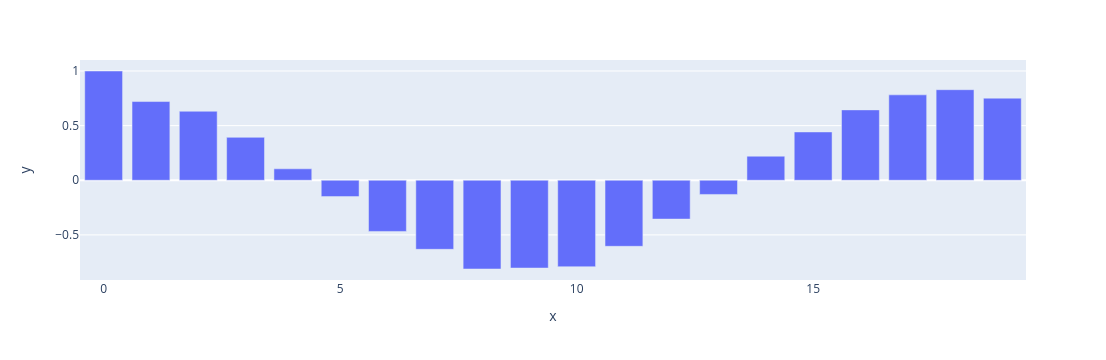

In [111]:
acf(err[:,0])

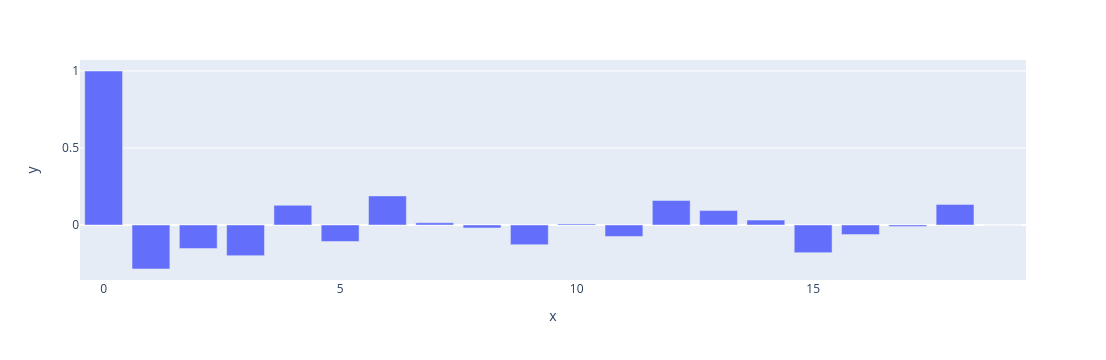

In [112]:
acf(err[:,1])

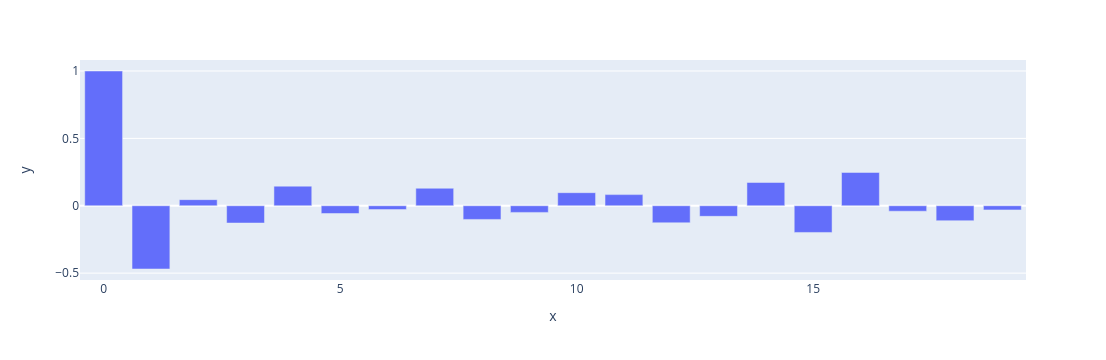

In [113]:
acf(err[:,2])